## Notebook to test visualisation plots and sample clustering algorithms

Best cheatsheet: https://www.kaggle.com/code/imoore/2d-and-3d-plotting-tutorial-in-python


In [99]:
from dataclasses import dataclass, field
from typing import Optional


@dataclass
class VisualizationConfig:
    """data class for all plotting configs"""

    figsize: tuple[int, int] = (12, 8)
    view_angles: Optional[dict[str, float]] = field(
        default_factory=lambda: {"azim": -66, "elev": 12}
    )
    plot_kwds: Optional[dict[str, float]] = field(
        default_factory=lambda: {
            "alpha": 0.80,
            "s": 80,
        }
    )
    title_fontsize: int = 16
    show_axes: bool = True
    axes_labels: Optional[dict[str, str]] = field(
        default_factory=lambda: {
            "x": "x-axis",
            "y": "y-axis",
            "z": "z-axis",
        }
    )

### Testing 2D visualisation

In [100]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

In [101]:
X, y = make_blobs(n_samples=2000, centers=4, n_features=2, random_state=1)
X, X.shape, X.ndim

(array([[-8.84245075, -3.6072908 ],
        [-6.3245052 , -3.00899595],
        [-7.06294419, -3.48759734],
        ...,
        [-0.38580398,  6.37359162],
        [-7.90333247, -9.45906106],
        [-0.85071555,  6.19624455]]),
 (2000, 2),
 2)

In [102]:
def plot2D(data: np.ndarray, title: str, colors: Optional[np.ndarray], config: VisualizationConfig):
    """
    Plots 2D data by taking in the data, title, colors and plot configs
    Args:
    data: data to be visualized
    title: title of the plot
    colors: optional colours 
    config: visualization configs
    """
    if data.ndim != 2 and data.shape[1] != 2:
        print("data is not the correct shape, should be (*, 2)")
        return
    fig = plt.figure(figsize=config.figsize)
    ax = fig.add_subplot()
    fig.add_axes(ax)
    ax.set_title(title, fontsize=config.title_fontsize)
    ax.set_xlabel(config.axes_labels["x"])
    ax.set_ylabel(config.axes_labels["y"])
    ax.scatter(
        data[:, 0],
        data[:, 1],
        **config.plot_kwds
    )
    # https://snyk.io/advisor/python/matplotlib/functions/matplotlib.pyplot.gca
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(config.show_axes)
    frame.axes.get_yaxis().set_visible(config.show_axes)
    frame

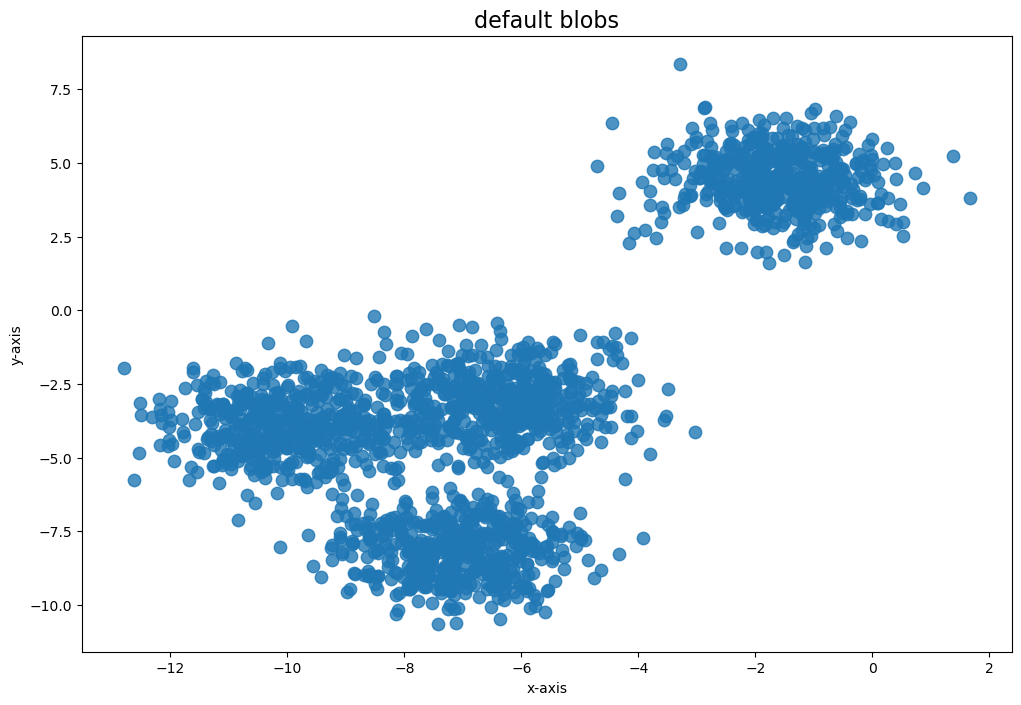

In [103]:
default_config = VisualizationConfig()
plot2D(data=X, title="default blobs",colors=None, config=default_config)

### Testing 3D visualisation
Mainly to visualise pose stamped messages

In [104]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets


In [105]:
swiss_roll_points, swiss_roll_colors = datasets.make_swiss_roll(
    n_samples=2000, random_state=1, noise=0.1
)
swiss_roll_points.shape, swiss_roll_colors.shape, len(swiss_roll_points)

((2000, 3), (2000,), 2000)

In [106]:
# select all rows and col 0
swiss_roll_points, swiss_roll_points[:, 0]

(array([[ -5.99406081,  12.18323716,   5.98274827],
        [  5.44516374,  18.49867144, -10.10315843],
        [ -0.04363331,  12.90360205,  -4.78936938],
        ...,
        [ 12.48734626,   1.60336108,  -0.52067625],
        [  1.28915959,  12.10066097,  -4.90075513],
        [  6.48848032,  15.34467741,  11.93027508]]),
 array([-5.99406081,  5.44516374, -0.04363331, ..., 12.48734626,
         1.28915959,  6.48848032]))

In [107]:
def plot3D(data: np.ndarray, title: str,colors: Optional[np.ndarray], config: VisualizationConfig):
    """
    Plots 3D data by taking in the data, title, colors and plot configs
    Args:
    data: data to be visualized
    title: title of the plot
    colors: optional colours 
    config: visualization configs
    """
    if data.ndim != 2 and data.shape[1] != 3: 
        print("data is not the correct shape, should be (*, 2)")
        return 
    fig = plt.figure(figsize=config.figsize)
    ax = fig.add_subplot(111, projection="3d")
    fig.add_axes(ax)
    ax.set_title(title, fontsize=config.title_fontsize)
    ax.scatter(
            data[:, 0], 
            data[:, 1], 
            data[:, 2],
            c=colors,
            **config.plot_kwds)
    # change view
    ax.view_init(**config.view_angles)
    ax.set_xlabel(config.axes_labels["x"])
    ax.set_ylabel(config.axes_labels["y"])
    ax.set_zlabel(config.axes_labels["z"])
    # add bottom text
    _ = ax.text2D(0.8, 0.05, s="n_samples=2000", transform=ax.transAxes)
    # https://snyk.io/advisor/python/matplotlib/functions/matplotlib.pyplot.gca
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(config.show_axes)
    frame.axes.get_yaxis().set_visible(config.show_axes)
    frame.axes.get_zaxis().set_visible(config.show_axes)
    frame

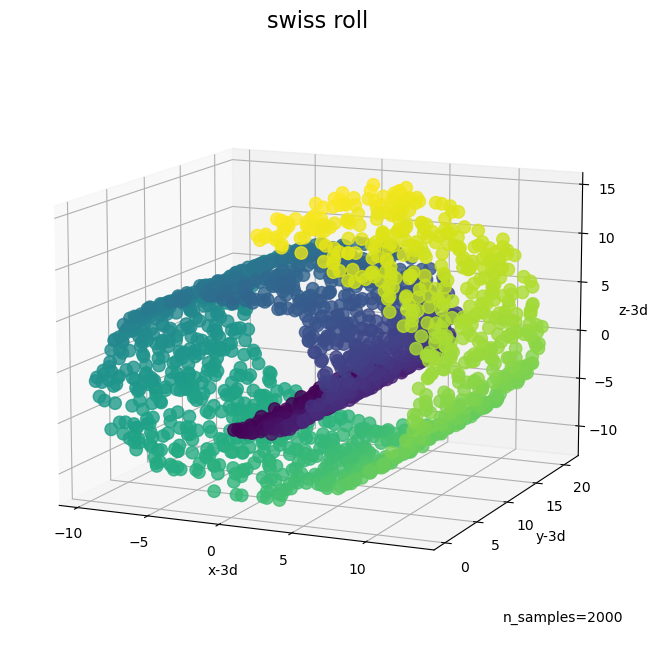

In [108]:
from dataclasses import replace
default_config = VisualizationConfig()
new_config = replace(
    default_config,
    axes_labels={
        "x": "x-3d",
        "y": "y-3d",
        "z": "z-3d",
    },
)
plot3D(
    swiss_roll_points,
    "swiss roll",
    colors=np.array(swiss_roll_colors),
    config=new_config,
)

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
# Apparently more aesthetic
import seaborn as sns
import time

In [110]:
def plot_clusters(data: np.ndarray, algorithm, args, kwds, config: VisualizationConfig):
    """
    Visualises the clustering result 
    Takes in the data, clustering algorithm used outputs the visualised plot
    Args:
        data: data to be clustered
        algorithm: name of clustering algorithm
        args, kwds: arguments for specific algorithm
    """
    if data.ndim != 2:
        print("data is not in the correct dimension to be plotted")
    if data.shape[1] not in [2, 3]:
        print("data is not the correct shape, shld be (*, 2) or (*, 3)")
    try:
        start_time = time.time()
        clusterer = algorithm(*args, **kwds)
        labels = clusterer.fit_predict(data)
        end_time = time.time()
        palette = sns.color_palette("deep", np.unique(labels).max() + 1)
        plot_colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
        plot_title = f"Clusters found by {str(algorithm.__name__)}, took {end_time - start_time} seconds"
        if data.shape[1] == 2:
            plot2D(data=data, title=plot_title, colors=plot_colors, config=config)
        if data.shape[1] == 3:
            plot3D(data=data, title=plot_title, colors=plot_colors, config=config)
    except TypeError as e:
        print(e)


## Test visualization with clustering algo 

In [111]:
algo = cluster.DBSCAN
arguments = ()
metrics = {"n_clusters": 6, "linkage": "ward"}

In [112]:
plot_clusters(
    data=swiss_roll_points,
    algorithm=algo,
    args=(),
    kwds=metrics,
    config=new_config
)

DBSCAN.__init__() got an unexpected keyword argument 'n_clusters'
